In [1]:
import pathlib
import json

In [2]:
import influxdb
import pandas as pd
import requests

In [3]:
from odapi.connectors import Irceline
from odapi.settings import settings
settings.logger.setLevel(50)

## Parameters

In [5]:
t1 = pd.Timestamp.utcnow().floor('1D')
t1

Timestamp('2020-06-23 00:00:00+0000', tz='UTC')

In [17]:
t0 = pd.Timestamp('2020-06-20 18:00:00', tz='CET').tz_convert('UTC')
t0 = t1 - pd.Timedelta('1D')

## SDS Benchmark

In [6]:
with pathlib.Path('C:/Users/admin/udlog/grafana.json').open() as fh:
    creds = json.load(fh)

In [7]:
rep = requests.get("http://helena.lan:3000/api/annotations", headers={'Authorization': 'Bearer ' + creds["token"]})

In [8]:
annot = pd.DataFrame(rep.json())
annot['time'] = pd.to_datetime(annot['time'], origin='unix', unit='ms')
annot['timeEnd'] = pd.to_datetime(annot['time'], origin='unix', unit='ms')
annot = annot[['id', 'time', 'timeEnd', 'text', 'tags', 'login', 'data']]
annot.tail()

,id,time,timeEnd,text,tags,login,data
48,49,2020-06-22 10:30:46.048,2020-06-22 10:30:46.048,Saturation,[],admin,{}
49,50,2020-06-22 10:32:21.214,2020-06-22 10:32:21.214,Breathcleaning,[],admin,{}
50,51,2020-06-22 10:34:01.968,2020-06-22 10:34:01.968,Plastic,[],admin,{}
51,52,2020-06-22 10:44:40.975,2020-06-22 10:44:40.975,Starting monitoring,[],admin,{}
52,53,2020-06-22 15:25:36.976,2020-06-22 15:25:36.976,Smoking a cigarette,[],admin,{}


In [9]:
annot.to_pickle('data/events.pickle')

## Raw Data

In [10]:
with pathlib.Path('C:/Users/admin/udlog/influx.json').open() as fh:
    data = json.load(fh)
    data["timeout"] = 60.0
    client = influxdb.InfluxDBClient(**data)

In [11]:
client.ping()

'1.8.0'

In [12]:
query = """
SELECT mean(pm25) AS pm25, mean(pm10) AS pm10
FROM "home"
WHERE time >= '{start:}' AND time < '{stop:}'
GROUP BY time(1s)
""".format(start=t0.isoformat(), stop=t1.isoformat())
print(query)


SELECT mean(pm25) AS pm25, mean(pm10) AS pm10
FROM "home"
WHERE time >= '2020-06-20T16:00:00+00:00' AND time < '2020-06-23T00:00:00+00:00'
GROUP BY time(1s)



In [13]:
r = client.query(query).raw['series'][0]

In [14]:
dsds = pd.DataFrame(r['values'], columns=r['columns'])
dsds['time'] = pd.to_datetime(dsds['time'])
dsds = dsds.set_index('time')
dsds.columns = pd.MultiIndex.from_tuples([('PM-2.5', 'Home', '1'), ('PM-10.0', 'Home', '2')])
dsds.tail()

,PM-2.5,PM-10.0
,Home,Home
,1,2
time,,
2020-06-22 23:59:55+00:00,4.8,18.3
2020-06-22 23:59:56+00:00,4.8,18.6
2020-06-22 23:59:57+00:00,4.8,18.6
2020-06-22 23:59:58+00:00,4.8,18.8
2020-06-22 23:59:59+00:00,4.9,19.4


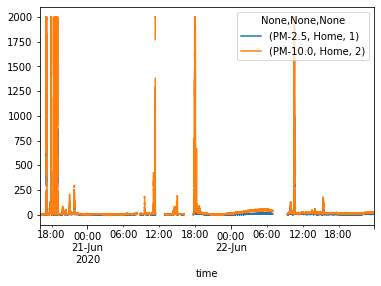

In [15]:
dsds.plot()

In [16]:
dsds.to_pickle("data/sds_backup_{:%Y-%m-%d}_{:%Y-%m-%d}.pickle".format(t0, t1))